# Text to SQL with Claude

## Introduction

Text to SQL is a natural language processing task that converts human-readable text queries into structured SQL queries. This lets users interact with databases using natural language. 

Claude can understand context, interpret complex queries, and generate accurate SQL statements. This guide focuses on using Claude to build a robust Text to SQL system.

## Why is Text to SQL Useful?

Text to SQL is valuable for several reasons:

1. **Accessibility**: Non-technical users can query databases without knowing SQL syntax, making data access easier within organizations.

2. **Efficiency**: Data analysts and scientists can quickly prototype queries using natural language.

3. **Integration**: It enables more intuitive interfaces for database interactions in applications and chatbots.

4. **Complex Query Generation**: LLMs can generate complex SQL queries involving multiple joins, subqueries, and aggregations, which can be time-consuming for humans to write.

## What This Guide Covers

This guide will walk you through building a Text to SQL system using LLMs. We'll cover:

1. Setting up a test SQLite database
2. Effective prompting for Text to SQL conversion
3. RAG (Retrieval Augmented Generation) to handle more complex database systems
4. Self-improvement and iteration of Claude's outputs
5. Evaluations

By the end of this guide, you'll understand how to implement and refine Text to SQL tasks using Claude, and have a framework for applying these techniques to your own projects.

## Table of Contents

1. [Introduction](#introduction)
2. [Setup](#setup)
3. [Creating a Basic Text to SQL Prompt](#creating-a-basic-text-to-sql-prompt)
4. [Improving the Prompt with Examples](#improving-the-prompt-with-examples)
5. [Using Chain-of-Thought Prompting](#using-chain-of-thought-prompting)
6. [Implementing RAG for Complex Database Schemas](#implementing-rag-for-complex-database-schemas)
7. [Implementing Query Self-Improvement](#implementing-query-self-improvement)
8. [Evaluations](#evaluations)

## Setup

Let's set up our environment and create a test SQLite database with two tables: `employees` and `departments`. We'll use this database throughout our guide.

In [1]:
%pip install -q anthropic pandas voyageai matplotlib seaborn

Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
from anthropic import Anthropic
import sqlite3
import pandas as pd
from IPython.display import display

# Set your Anthropic API key
os.environ["ANTHROPIC_API_KEY"] = "YOUR_ANTHROPIC_API_KEY"
os.environ["VOYAGE_API_KEY"] = "YOUR_VOYAGE_API_KEY"

# Initialize the Anthropic client
client = Anthropic()
MODEL_NAME = "claude-3-5-sonnet-20240620"

# Filepath to the SQLite database
DATABASE_PATH = "data/data.db"

### Create a Test Database

In [3]:
import random
from datetime import datetime, timedelta

if not os.path.exists(DATABASE_PATH):
    print("Database does not exist. Creating and populating...")
    # Create a new SQLite database and tables
    with sqlite3.connect(DATABASE_PATH) as conn:
        cursor = conn.cursor()
        
        cursor.executescript('''
        CREATE TABLE IF NOT EXISTS departments (
            id INTEGER PRIMARY KEY,
            name TEXT NOT NULL,
            location TEXT
        );
        CREATE TABLE IF NOT EXISTS employees (
            id INTEGER PRIMARY KEY,
            name TEXT NOT NULL,
            age INTEGER,
            department_id INTEGER,
            salary REAL,
            hire_date DATE,
            FOREIGN KEY (department_id) REFERENCES departments (id)
        );
        ''')

        # Insert sample data
        cursor.executemany('INSERT OR REPLACE INTO departments VALUES (?,?,?)',
            [
                (1, 'HR', 'New York'), 
                (2, 'Engineering', 'San Francisco'), 
                (3, 'Marketing', 'Chicago'),
                (4, 'Sales', 'Los Angeles'),
                (5, 'Finance', 'Boston'),
                (6, 'Customer Support', 'Dallas'),
                (7, 'Research', 'Seattle'),
                (8, 'Legal', 'Washington D.C.'),
                (9, 'Product', 'Austin'),
                (10, 'Operations', 'Denver')
            ])
        
        first_names = ['John', 'Jane', 'Bob', 'Alice', 'Charlie', 'Diana', 'Edward', 'Fiona', 'George', 'Hannah', 'Ian', 'Julia', 'Kevin', 'Laura', 'Michael', 'Nora', 'Oliver', 'Patricia', 'Quentin', 'Rachel', 'Steve', 'Tina', 'Ulysses', 'Victoria', 'William', 'Xena', 'Yannick', 'Zoe']
        last_names = ['Smith', 'Johnson', 'Williams', 'Jones', 'Brown', 'Davis', 'Miller', 'Wilson', 'Moore', 'Taylor', 'Anderson', 'Thomas', 'Jackson', 'White', 'Harris', 'Martin', 'Thompson', 'Garcia', 'Martinez', 'Robinson', 'Clark', 'Rodriguez', 'Lewis', 'Lee', 'Walker', 'Hall', 'Allen', 'Young', 'King']

        employees_data = []
        for i in range(1, 201):  # Generate 200 employees
            name = f"{random.choice(first_names)} {random.choice(last_names)}"
            age = random.randint(22, 65)
            department_id = random.randint(1, 10)
            salary = round(random.uniform(40000, 200000), 2)
            hire_date = (datetime.now() - timedelta(days=random.randint(0, 3650))).strftime('%Y-%m-%d')
            employees_data.append((i, name, age, department_id, salary, hire_date))

        cursor.executemany('INSERT OR REPLACE INTO employees VALUES (?,?,?,?,?,?)', employees_data)

# Display table contents
for table in ['departments', 'employees']:
    df = pd.read_sql_query(f"SELECT * FROM {table}", conn)
    print(f"\n{table.capitalize()} table:")
    display(df)


Departments table:


,id,name,location
0,1,HR,New York
1,2,Engineering,San Francisco
2,3,Marketing,Chicago
3,4,Sales,Los Angeles
4,5,Finance,Boston
5,6,Customer Support,Dallas
6,7,Research,Seattle
7,8,Legal,Washington D.C.
8,9,Product,Austin
9,10,Operations,Denver



Employees table:


,id,name,age,department_id,salary,hire_date
0,1,Quentin Thompson,44,4,158025.68,2022-03-17
1,2,Fiona Jones,46,4,141201.47,2022-03-20
2,3,Ian Jackson,55,9,178160.89,2021-04-26
3,4,William Lee,37,10,102357.60,2018-06-22
4,5,Julia White,51,9,129467.06,2020-05-11
...,...,...,...,...,...,...
195,196,Victoria Lee,45,9,173869.38,2019-07-28
196,197,Kevin Smith,54,8,85683.09,2016-02-27
197,198,Charlie Young,43,10,180179.93,2017-09-26
198,199,Diana Davis,35,5,45012.69,2023-11-13


## Creating a Basic Text to SQL Prompt

Now that we have our database set up, let's create a basic prompt for Text to SQL conversion. A good prompt should include:

1. Clear instructions for what we want the model to do
2. The user's query
3. The database's schema, so Claude knows how to translate the user's query


In [4]:
def get_schema_info(db_path):
    conn = sqlite3.connect(db_path)
    cursor = conn.cursor()
    
    schema_info = []
    
    # Get all tables
    cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
    tables = cursor.fetchall()
    
    for (table_name,) in tables:
        # Get columns for this table
        cursor.execute(f"PRAGMA table_info({table_name})")
        columns = cursor.fetchall()
        
        table_info = f"Table: {table_name}\n"
        table_info += "\n".join(f"  - {col[1]} ({col[2]})" for col in columns)
        schema_info.append(table_info)
    
    conn.close()
    return "\n\n".join(schema_info)

# Get the schema info
schema = get_schema_info(DATABASE_PATH)
print(schema)

Table: departments
  - id (INTEGER)
  - name (TEXT)
  - location (TEXT)

Table: employees
  - id (INTEGER)
  - name (TEXT)
  - age (INTEGER)
  - department_id (INTEGER)
  - salary (REAL)
  - hire_date (DATE)


Now that we have our schema information, let's create a basic prompt:

In [5]:
def generate_prompt(schema, query):
    return f"""
        You are an AI assistant that converts natural language queries into SQL.
        Given the following SQL database schema:

        <schema>
        {schema}
        </schema>

        Convert the following natural language query into SQL:
        <query>
        {query}
        </query>

        Provide only the SQL query in your response, enclosed within <sql> tags.
    """

# Test the prompt
user_query = "What are the names of all employees in the Engineering department?"
prompt = generate_prompt(schema, user_query)
print(prompt)


        You are an AI assistant that converts natural language queries into SQL.
        Given the following SQL database schema:

        <schema>
        Table: departments
  - id (INTEGER)
  - name (TEXT)
  - location (TEXT)

Table: employees
  - id (INTEGER)
  - name (TEXT)
  - age (INTEGER)
  - department_id (INTEGER)
  - salary (REAL)
  - hire_date (DATE)
        </schema>

        Convert the following natural language query into SQL:
        <query>
        What are the names of all employees in the Engineering department?
        </query>

        Provide only the SQL query in your response, enclosed within <sql> tags.
    


Now let's use this prompt with the Anthropic API to generate SQL:

In [6]:
def generate_sql(prompt):
    response = client.messages.create(
        model=MODEL_NAME,
        max_tokens=1000,
        temperature=0,
        messages=[
            {"role": "user", "content": prompt}
        ]
    )
    return response.content[0].text.strip()

# Generate SQL
result = generate_sql(prompt)
sql = result.split('<sql>')[1].split('</sql>')[0].strip()
print("Generated SQL:")
print(sql)

Generated SQL:
SELECT e.name
FROM employees e
JOIN departments d ON e.department_id = d.id
WHERE d.name = 'Engineering';


Let's test our generated SQL by running it against our database:

In [7]:
def run_sql(sql):
    conn = sqlite3.connect(DATABASE_PATH)
    result = pd.read_sql_query(sql, conn)
    conn.close()
    return result

result = run_sql(sql)
print("Query result:")
display(result)

Query result:


,name
0,Nora Martin
1,Oliver Robinson
2,Julia Walker
3,William Davis
4,Quentin Harris
5,Julia Rodriguez
6,Julia Jackson
7,John Wilson
8,Kevin Anderson
9,Julia Walker


## Improving the Prompt with Examples

Our basic prompt works, but we can make it more effective by including examples. This technique, called few-shot learning, helps the model understand the task better by providing concrete examples of input-output pairs.

Let's modify our `generate_prompt` function to include some examples:

In [8]:
def generate_prompt_with_examples(schema, query):
    examples = """
        Example 1:
        <query>List all employees in the HR department.</<query>
        <output>SELECT e.name FROM employees e JOIN departments d ON e.department_id = d.id WHERE d.name = 'HR';</output>

        Example 2:
        User: What is the average salary of employees in the Engineering department?
        SQL: SELECT AVG(e.salary) FROM employees e JOIN departments d ON e.department_id = d.id WHERE d.name = 'Engineering';

        Example 3:
        User: Who is the oldest employee?
        SQL: SELECT name, age FROM employees ORDER BY age DESC LIMIT 1;
    """

    return f"""
        You are an AI assistant that converts natural language queries into SQL.
        Given the following SQL database schema:

        <schema>
        {schema}
        </schema>

        Here are some examples of natural language queries and their corresponding SQL:

        <examples>
        {examples}
        </examples>

        Now, convert the following natural language query into SQL:
        <query>
        {query}
        </query>

        Provide only the SQL query in your response, enclosed within <sql> tags.
    """

# Test the new prompt
user_query = "What are the names and salaries of employees in the Marketing department?"
prompt = generate_prompt_with_examples(schema, user_query)
print(prompt)


        You are an AI assistant that converts natural language queries into SQL.
        Given the following SQL database schema:

        <schema>
        Table: departments
  - id (INTEGER)
  - name (TEXT)
  - location (TEXT)

Table: employees
  - id (INTEGER)
  - name (TEXT)
  - age (INTEGER)
  - department_id (INTEGER)
  - salary (REAL)
  - hire_date (DATE)
        </schema>

        Here are some examples of natural language queries and their corresponding SQL:

        <examples>
        
        Example 1:
        <query>List all employees in the HR department.</<query>
        <output>SELECT e.name FROM employees e JOIN departments d ON e.department_id = d.id WHERE d.name = 'HR';</output>

        Example 2:
        User: What is the average salary of employees in the Engineering department?
        SQL: SELECT AVG(e.salary) FROM employees e JOIN departments d ON e.department_id = d.id WHERE d.name = 'Engineering';

        Example 3:
        User: Who is the oldest employee?


Now let's use this improved prompt to generate SQL:

In [9]:
# Generate SQL using the improved prompt
result = generate_sql(prompt)
sql = result.split('<sql>')[1].split('</sql>')[0].strip()
print("Generated SQL:")
print(sql)

# Run the generated SQL
result = run_sql(sql)
print("\nQuery result:")
display(result)

Generated SQL:
SELECT e.name, e.salary
FROM employees e
JOIN departments d ON e.department_id = d.id
WHERE d.name = 'Marketing';

Query result:


,name,salary
0,Patricia White,154248.96
1,Xena Robinson,71097.53
2,Oliver Young,109932.61
3,Yannick Lee,170835.51
4,Fiona Martinez,77035.10
5,Michael Miller,114438.20
6,Steve Thomas,48307.29
7,Julia Lewis,176692.05
8,Laura Jones,80066.42
9,Oliver King,134042.01


By including examples in our prompt, we've given the model a better understanding of how to structure its responses. This can lead to more accurate and consistent SQL generation, especially for more complex queries.

In the next section, we'll explore how to handle more complex queries and improve the model's reasoning process using chain-of-thought prompting.

## Using Chain-of-Thought Prompting

Chain-of-thought prompting encourages the model to break down complex problems into steps. For Text to SQL tasks, this can help with more complex queries that require multiple operations or careful consideration of the database schema.

Let's modify our prompt to incorporate chain-of-thought reasoning using XML tags:

In [10]:
def generate_prompt_with_cot(schema, query):
    examples = """
    <example>
    <query>List all employees in the HR department.</query>
    <thought_process>
    1. We need to join the employees and departments tables.
    2. We'll match employees.department_id with departments.id.
    3. We'll filter for the HR department.
    4. We only need to return the employee names.
    </thought_process>
    <sql>SELECT e.name FROM employees e JOIN departments d ON e.department_id = d.id WHERE d.name = 'HR';</sql>
    </example>

    <example>
    <query>What is the average salary of employees hired in 2022?</query>
    <thought_process>
    1. We need to work with the employees table.
    2. We need to filter for employees hired in 2022.
    3. We'll use the YEAR function to extract the year from the hire_date.
    4. We'll calculate the average of the salary column for the filtered rows.
    </thought_process>
    <sql>SELECT AVG(salary) FROM employees WHERE YEAR(hire_date) = 2022;</sql>
    </example>
    """

    return f"""You are an AI assistant that converts natural language queries into SQL.
    Given the following SQL database schema:

    <schema>
    {schema}
    </schema>

    Here are some examples of natural language queries, thought processes, and their corresponding SQL:

    <examples>
    {examples}
    </examples>

    Now, convert the following natural language query into SQL:
    <query>
    {query}
    </query>

    Within <thought_process> tags, explain your thought process for creating the SQL query.
    Then, within <sql> tags, provide your output SQL query.
    """

# Test the new prompt
user_query = "What are the names and hire dates of employees in the Engineering department, ordered by their salary?"
prompt = generate_prompt_with_cot(schema, user_query)
print(prompt)

You are an AI assistant that converts natural language queries into SQL.
    Given the following SQL database schema:

    <schema>
    Table: departments
  - id (INTEGER)
  - name (TEXT)
  - location (TEXT)

Table: employees
  - id (INTEGER)
  - name (TEXT)
  - age (INTEGER)
  - department_id (INTEGER)
  - salary (REAL)
  - hire_date (DATE)
    </schema>

    Here are some examples of natural language queries, thought processes, and their corresponding SQL:

    <examples>
    
    <example>
    <query>List all employees in the HR department.</query>
    <thought_process>
    1. We need to join the employees and departments tables.
    2. We'll match employees.department_id with departments.id.
    3. We'll filter for the HR department.
    4. We only need to return the employee names.
    </thought_process>
    <sql>SELECT e.name FROM employees e JOIN departments d ON e.department_id = d.id WHERE d.name = 'HR';</sql>
    </example>

    <example>
    <query>What is the average salary

Now let's use this chain-of-thought prompt with XML tags to generate SQL:

In [11]:
def generate_sql_with_cot(prompt):
    response = client.messages.create(
        model=MODEL_NAME,
        max_tokens=1000,
        temperature=0,
        messages=[
            {"role": "user", "content": prompt}
        ]
    )
    return response.content[0].text.strip()

# Generate SQL using the chain-of-thought prompt
result = generate_sql_with_cot(prompt)
print("Raw response from Claude:")
print(result)

# Extract thought process and SQL query using simple string manipulation
# Note: For more robust parsing, consider using an XML parsing library
thought_process = result.split('<thought_process>')[1].split('</thought_process>')[0].strip()
sql = result.split('<sql>')[1].split('</sql>')[0].strip()

print("\nThought Process:")
print(thought_process)

print("\nGenerated SQL:")
print(sql)

# Run the generated SQL
query_result = run_sql(sql)
print("\nQuery result:")
display(query_result)

Raw response from Claude:
<thought_process>
1. We need to join the employees and departments tables to get the department information.
2. We'll match employees.department_id with departments.id.
3. We need to filter for the Engineering department.
4. We need to select the names and hire dates of the employees.
5. We need to order the results by the employees' salaries.
6. We don't need to show the salary in the output, but we'll use it for ordering.
</thought_process>

<sql>
SELECT e.name, e.hire_date
FROM employees e
JOIN departments d ON e.department_id = d.id
WHERE d.name = 'Engineering'
ORDER BY e.salary;
</sql>

Thought Process:
1. We need to join the employees and departments tables to get the department information.
2. We'll match employees.department_id with departments.id.
3. We need to filter for the Engineering department.
4. We need to select the names and hire dates of the employees.
5. We need to order the results by the employees' salaries.
6. We don't need to show the s

,name,hire_date
0,Julia Walker,2020-10-20
1,Laura Lewis,2018-08-06
2,Julia Walker,2016-08-21
3,Julia Jackson,2020-07-17
4,Patricia Brown,2017-07-08
5,John Wilson,2023-05-16
6,Laura Clark,2022-10-30
7,Zoe Thomas,2020-09-04
8,Julia Rodriguez,2016-03-21
9,Oliver Moore,2015-04-20


## Implementing RAG for Complex Database Schemas

As databases grow larger and more complex, providing the entire schema in each prompt becomes impractical. Retrieval Augmented Generation (RAG) can helps manage this complexity by dynamically retrieving the most relevant schema information based on the user's query. 

First, lets build a simple VectorDB class that leverages the embedding models created by VoyageAI:

In [12]:
import os
import numpy as np
import voyageai
import pickle
import json
import sqlite3

class VectorDB:
    def __init__(self, db_path='./data/vector_db.pkl'):
        self.client = voyageai.Client(api_key=os.getenv("VOYAGE_API_KEY"))
        self.db_path = db_path
        self.load_db()

    def load_db(self):
        if os.path.exists(self.db_path):
            with open(self.db_path, "rb") as file:
                data = pickle.load(file)
            self.embeddings, self.metadata, self.query_cache = data['embeddings'], data['metadata'], json.loads(data['query_cache'])
        else:
            self.embeddings, self.metadata, self.query_cache = [], [], {}

    def load_data(self, data):
        if not self.embeddings:
                texts = [item["text"] for item in data]
                self.embeddings = [emb for batch in range(0, len(texts), 128) 
                                    for emb in self.client.embed(texts[batch:batch+128], model="voyage-2").embeddings]
                self.metadata = [item["metadata"] for item in data]  # Store only the inner metadata
                self.save_db()

    def search(self, query, k=5, similarity_threshold=0.3):
        if query not in self.query_cache:
            self.query_cache[query] = self.client.embed([query], model="voyage-2").embeddings[0]
            self.save_db()
        
        similarities = np.dot(self.embeddings, self.query_cache[query])
        top_indices = np.argsort(similarities)[::-1]
        
        return [{"metadata": self.metadata[i], "similarity": similarities[i]} 
                for i in top_indices if similarities[i] >= similarity_threshold][:k]

    def save_db(self):
        with open(self.db_path, "wb") as file:
            pickle.dump({"embeddings": self.embeddings, "metadata": self.metadata, 
                         "query_cache": json.dumps(self.query_cache)}, file)

# Initialize and load schema data
vectordb = VectorDB()
if not vectordb.embeddings:
    with sqlite3.connect(DATABASE_PATH) as conn:
        cursor = conn.cursor()
        cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
        schema_data = [
            {"text": f"Table: {table[0]}, Column: {col[1]}, Type: {col[2]}", 
             "metadata": {"table": table[0], "column": col[1], "type": col[2]}}
            for table in cursor.fetchall()
            for col in cursor.execute(f"PRAGMA table_info({table[0]})").fetchall()
        ]
    vectordb.load_data(schema_data)

# Test the search functionality
test_query = "What is the average salary of employees in each department?"
results = vectordb.search(test_query)
print("Search results:")
for result in results:
    print(f"Similarity: {result['similarity']}, Metadata: {result['metadata']}")

Search results:
Similarity: 0.7318002364429477, Metadata: {'table': 'employees', 'column': 'salary', 'type': 'REAL'}
Similarity: 0.728456954795667, Metadata: {'table': 'employees', 'column': 'department_id', 'type': 'INTEGER'}
Similarity: 0.6810496067975434, Metadata: {'table': 'departments', 'column': 'name', 'type': 'TEXT'}
Similarity: 0.6697669330753087, Metadata: {'table': 'employees', 'column': 'name', 'type': 'TEXT'}
Similarity: 0.6666317064533498, Metadata: {'table': 'departments', 'column': 'location', 'type': 'TEXT'}


Now, let's update our prompt generation function to use RAG:

In [13]:
def generate_prompt_with_rag(query):
    relevant_schema = vectordb.search(query, k=10, similarity_threshold=0.3)
    schema_info = "\n".join([f"Table: {item['metadata']['table']}, Column: {item['metadata']['column']}, Type: {item['metadata']['type']}" 
                             for item in relevant_schema])
    
    return f"""You are an AI assistant that converts natural language queries into SQL.
    Given the following relevant columns from the SQL database schema:

    <schema>
    {schema_info}
    </schema>

    Convert the following natural language query into SQL:
    <query>
    {query}
    </query>

    Within <thought_process> tags, explain your thought process for creating the SQL query.
    Then, within <sql> tags, provide your output SQL query.
    """

# Test the RAG-based prompt
user_query = "What is the average salary of employees in each department?"
prompt = generate_prompt_with_rag(user_query)
print("Generated prompt:")
print(prompt)

# Generate and execute SQL
result = generate_sql_with_cot(prompt)
print("\nGenerated result:")
print(result)

# Extract and run the SQL query
sql = result.split('<sql>')[1].split('</sql>')[0].strip()
print("\nExtracted SQL:")
print(sql)

query_result = run_sql(sql)
print("\nQuery result:")
display(query_result)

Generated prompt:
You are an AI assistant that converts natural language queries into SQL.
    Given the following relevant columns from the SQL database schema:

    <schema>
    Table: employees, Column: salary, Type: REAL
Table: employees, Column: department_id, Type: INTEGER
Table: departments, Column: name, Type: TEXT
Table: employees, Column: name, Type: TEXT
Table: departments, Column: location, Type: TEXT
Table: employees, Column: id, Type: INTEGER
Table: departments, Column: id, Type: INTEGER
Table: employees, Column: age, Type: INTEGER
Table: employees, Column: hire_date, Type: DATE
    </schema>

    Convert the following natural language query into SQL:
    <query>
    What is the average salary of employees in each department?
    </query>

    Within <thought_process> tags, explain your thought process for creating the SQL query.
    Then, within <sql> tags, provide your output SQL query.
    

Generated result:
<thought_process>
To answer this query, we need to:
1. Join 

,department_name,average_salary
0,Customer Support,126537.867647
1,Engineering,118840.745000
2,Finance,116991.758636
3,HR,116208.757143
4,Legal,122879.550714
5,Marketing,104953.144000
6,Operations,124291.679310
7,Product,113950.742083
8,Research,129433.336190
9,Sales,124225.143500


## Implementing Query Self-Improvement

Here, we'll build a self-improvement loop with Claude. This lets Claude execute the SQL it generates, analyze the results or errors, and improve the query if necessary.

This technique helps with:

1. Error Handling: It can catch and respond to SQL syntax errors or other execution issues.
2. Iterative Refinement: The model can learn from its mistakes and thought processes, and improve its output.
3. Performance: It increases the likelihood of generating a valid and executable SQL query.

In practice, you might want to adjust the `max_attempts` value based on your specific use case and performance requirements.

Let's start by creating a function that tries to execute the SQL and provides feedback:

In [14]:
def execute_sql_with_feedback(sql):
    try:
        result = run_sql(sql)
        return True, result, "Query executed successfully."
    except Exception as e:
        return False, None, str(e)

def generate_prompt_with_self_improvement(query, max_attempts=3):
    feedback = None
    sql = None

    for attempt in range(max_attempts):
        if attempt == 0:
            prompt = generate_prompt_with_rag(query)
        else:
            prompt = f"""
            The previous SQL query resulted in this error: {feedback}
            Analyze the error and provide an improved SQL query.
            Original query: {sql}
            Explain your changes in <thought_process> tags and provide the corrected SQL in <sql> tags.
            """
        
        response = generate_sql_with_cot(prompt)
        sql = response.split('<sql>')[1].split('</sql>')[0].strip()
        
        print(f"\nAttempt {attempt + 1}:")
        
        success, result, feedback = execute_sql_with_feedback(sql)
        if success:
            print("SQL executed successfully!")
            return sql, result
        else:
            print("SQL failed to execute")

    print("Maximum attempts reached. Could not generate a valid SQL query.")
    return None, None

# Test the self-improving SQL generation
user_query = "For each department, show the ratio of the highest paid employee's salary to the lowest paid employee's salary, but only for departments where this ratio is greater than 3"
final_sql, result = generate_prompt_with_self_improvement(user_query)

if final_sql:
    print("\nFinal SQL query:")
    print(final_sql)
    print("\nQuery result:")
    display(result)
else:
    print("Failed to generate a valid SQL query.")


Attempt 1:
SQL failed to execute

Attempt 2:
SQL executed successfully!

Final SQL query:
WITH department_salary_ratios AS (
    SELECT 
        d.name AS department_name,
        salary_range.max_salary / salary_range.min_salary AS salary_ratio
    FROM 
        (SELECT 
            department_id,
            MAX(salary) AS max_salary,
            MIN(salary) AS min_salary
        FROM 
            employees
        GROUP BY 
            department_id) AS salary_range
    JOIN 
        departments d ON d.id = salary_range.department_id
)
SELECT 
    department_name,
    salary_ratio
FROM 
    department_salary_ratios
WHERE 
    salary_ratio > 3
ORDER BY 
    salary_ratio DESC

Query result:


,department_name,salary_ratio
0,Sales,4.619684
1,Engineering,4.615959
2,Product,4.564688
3,Finance,4.522133
4,Operations,4.414014
5,Marketing,4.303247
6,Customer Support,3.968905
7,Legal,3.728458
8,HR,3.490148
9,Research,3.002950


This self-improvement loop makes our Text to SQL system far more reliable for real-world applications.

## Evaluations

Evaluating Text to SQL systems isn't always straightforward. A SQL query might be written correctly but not give the right answer, or it might work but not be the best way to get the result. Some queries are simple and easy to generate, while others are very complex.

Here, we'll explore building an evaluation framework using [Promptfoo](https://promptfoo.dev), an open source LLM evaluation toolkit. To get started,check out `./evaluation/README.md`.

You can run an evaluation with the command `promptfoo eval`. You can render the eval results via the command `npx promptfoo@latest`. Here's a preview of what the results look like:

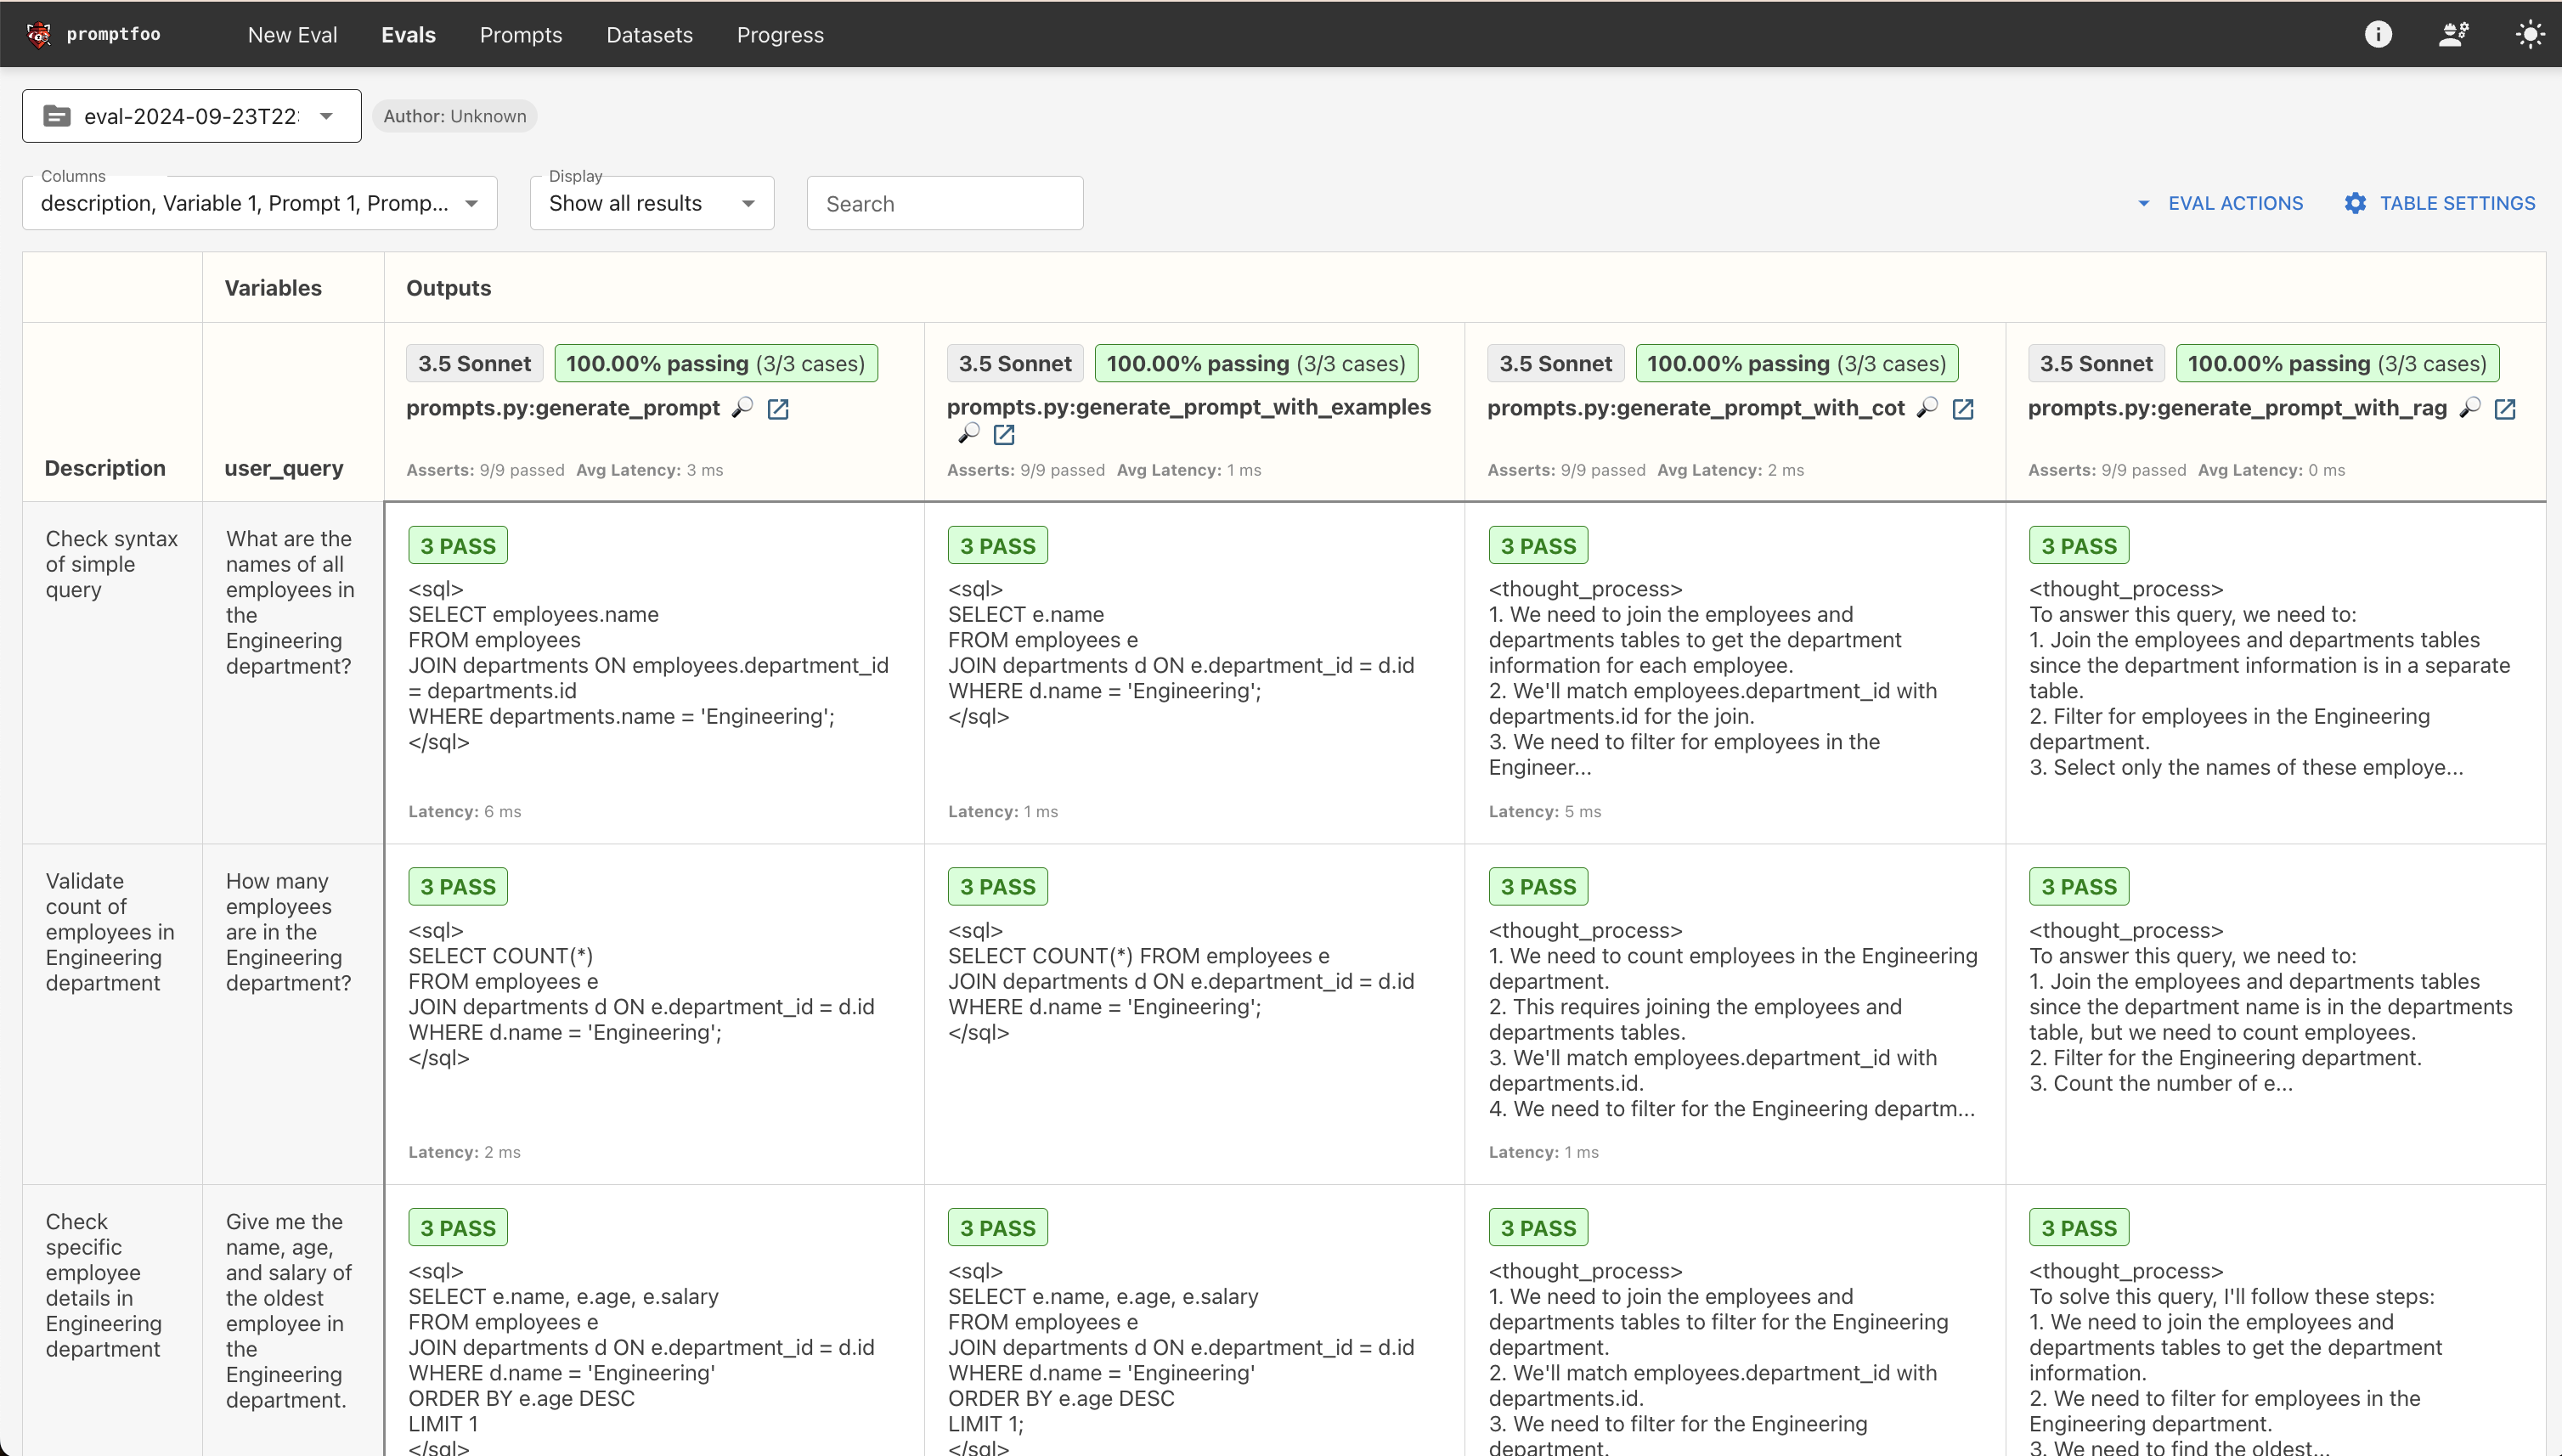